In [2]:
# Set the notebook to automatically reload modules before executing code
%load_ext autoreload
%autoreload 2

# %matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from qqgjyx import QQ

import matplotlib.pyplot as plt
QQ.style()

# RMS Permutation Demo
---

## Importing Packages

In [4]:
import numpy as np
import pandas as pd
from mheatmap import (
    amc_postprocess, 
    rms_permute, 
    mosaic_heatmap
)
import scipy
import warnings

## Load Data

- Load the ground truth labels
    - `Salinas_gt.mat`: Ground truth labels for [Salinas dataset](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes)
- Load the predicted labels from `spectral clustering`

In [5]:
# Load the data
y_true = scipy.io.loadmat("data/Salinas_gt.mat")["salinas_gt"].reshape(-1)
# Load predicted labels from spectral clustering
y_pred = np.array(
    pd.read_csv(
        "data/Salinas_spectralclustering.csv",
        header=None,
        low_memory=False,
    )
    .values[1:]
    .flatten()
)
print(f"y_true shape: {y_true.shape}")
print(f"y_pred shape: {len(y_pred)}")

y_true shape: (111104,)
y_pred shape: 111104


## AMC Post-processing

- Alignment with `Hungarian` algorithm
- Masking the zeros (unlabeled pixels) with [mask_zeros_from_gt](../api/amc-postprocess#mask_zeros_from_gt)
- Computing the confusion matrix

See [AMC Post-processing](../api/amc-postprocess) for more details.

In [6]:
# AMC post-processing
_, conf_mat, labels = amc_postprocess(y_pred, y_true)

## RMS Permutation
- Reverse Merge/Split Idea:
    - Merge: $GT0, GT1 \rightarrow PRD0, PRD0$
    - Split: $GT0, GT0 \rightarrow PRD0, PRD1$
    - Which impact OA or AA metrics but not ARI (`resolution issue`)

In [7]:
# Demonstrate RMS permutation analysis
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    rms_C, rms_labels, _, rms_map_matrix, rms_map_type = rms_permute(conf_mat, labels)

## Visualize the results

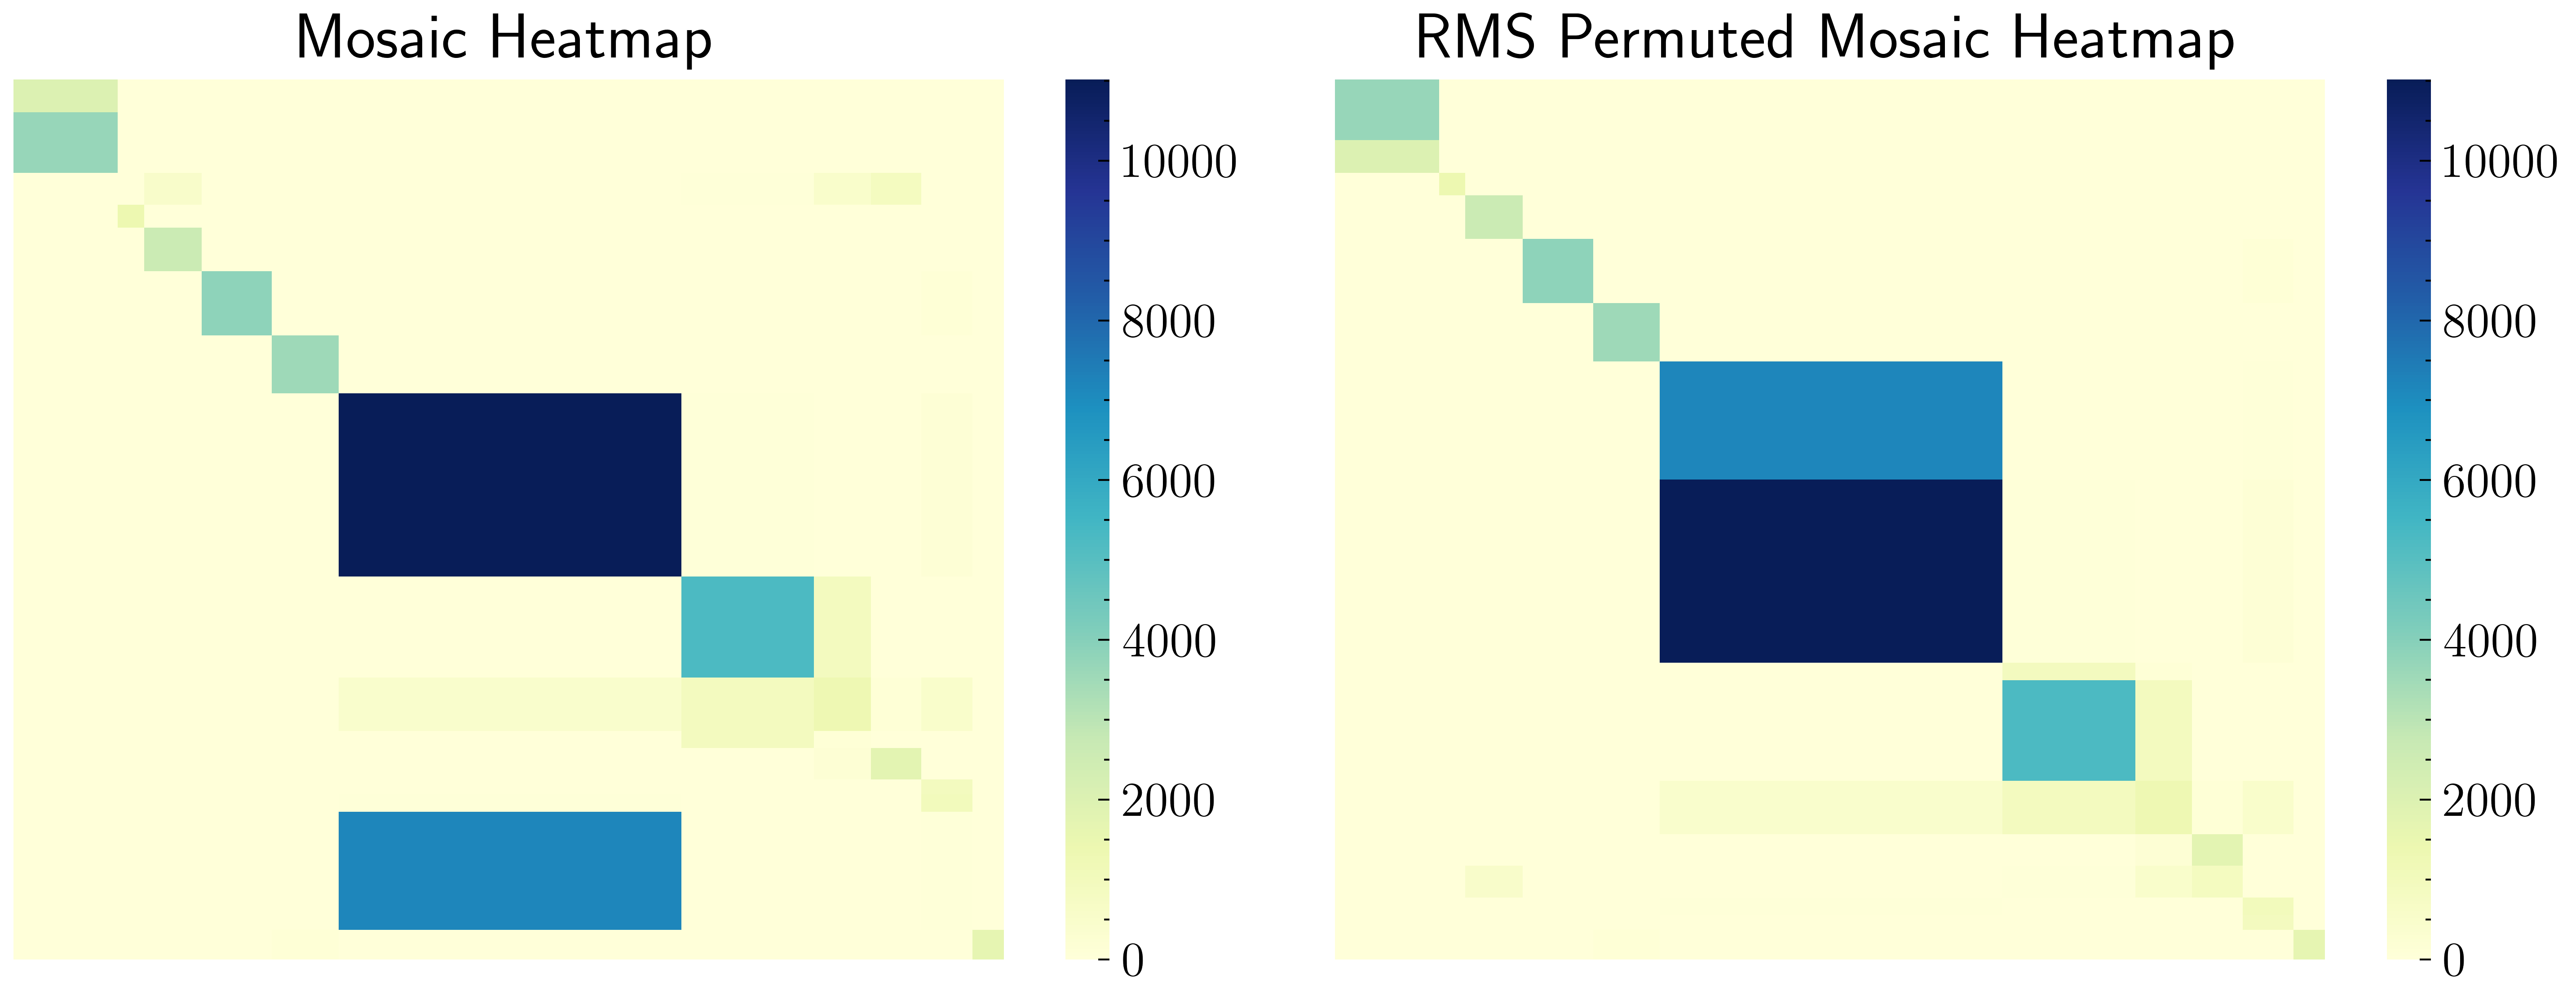

In [25]:
# Visualize original vs RMS permuted matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

mosaic_heatmap(conf_mat, ax=ax1, xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
ax1.set_title("Mosaic Heatmap")
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xticks([])
ax1.set_yticks([])

mosaic_heatmap(
    rms_C, ax=ax2, xticklabels=rms_labels, yticklabels=rms_labels, cmap="YlGnBu"
)
ax2.set_title("RMS Permuted Mosaic Heatmap")
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

## RMS Matrix Visualization
---

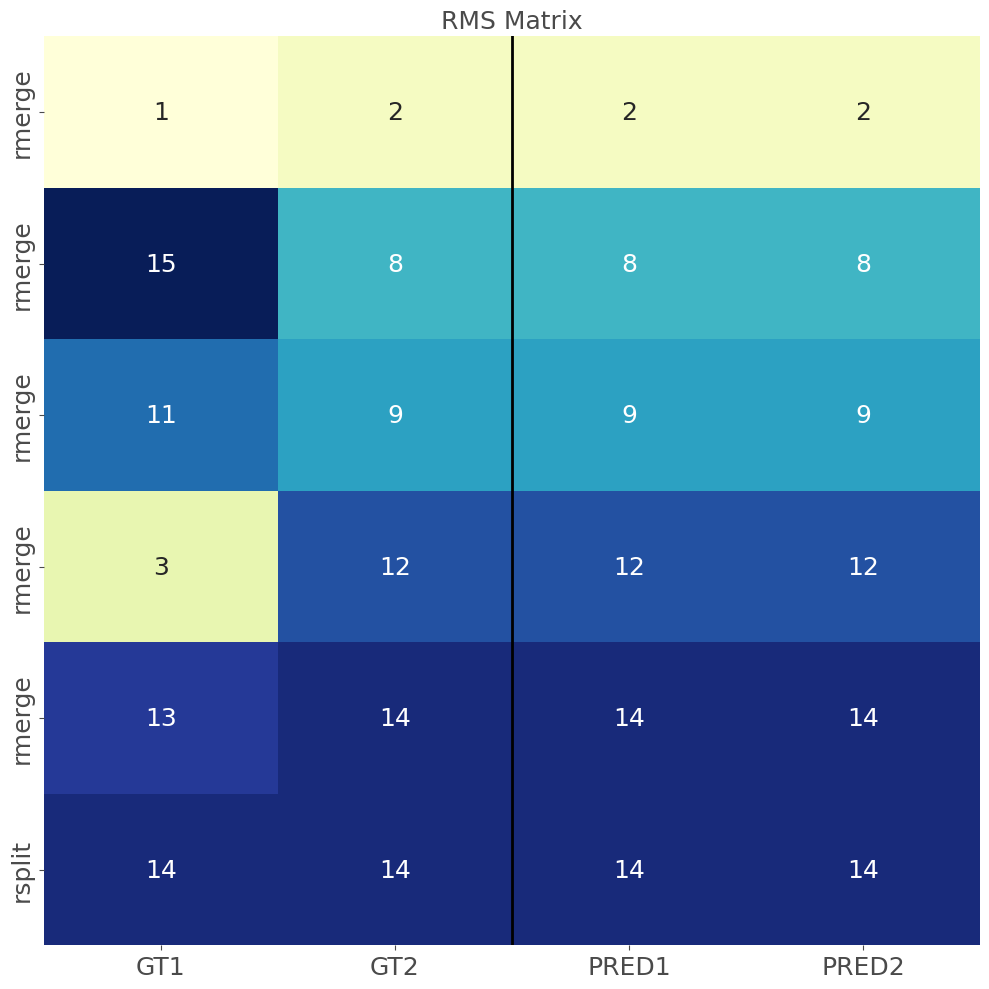

In [6]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    rms_map_matrix, 
    annot=True, 
    annot_kws={"size": 18},
    cbar=False,
    cmap="YlGnBu",
    xticklabels=['GT1', 'GT2', 'PRED1', 'PRED2'],
    yticklabels=rms_map_type
)
ax.set_title("RMS Matrix", fontsize=18, color='#4A4A4A')  # Medium gray
ax.tick_params(colors='#4A4A4A', axis='both', which='major', labelsize=18)
ax.axvline(x=2, color='black', linewidth=2)
plt.tight_layout()
plt.savefig("rms_matrix.png", dpi=300, transparent=True)
plt.show()